In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from abc import ABC, abstractmethod
from subprocess import call
from IPython.display import Image
from sklearn.model_selection import train_test_split as dataSplitter
from sklearn.model_selection import GridSearchCV
from sklearn.base import ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier as skKNN
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.svm import SVC as skSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score

In [173]:
class Algo:
	def __init__(self,trainData,testData):
		self.classifier  = ClassifierMixin()
		self.train(trainData)
		self.test = testData
	@abstractmethod
	def train(self,data):
		pass
	@abstractmethod
	def getName(self,data):
		pass
	def score(self):
		print(self.getName()+": "+str(f1_score(self.test['isPhoton'],self.estimate(self.test.drop(['isPhoton'],axis=1)),average='binary',sample_weight=compute_sample_weight({0:.995,1:.005},self.test['isPhoton']))))
	def best_param(self):
		print(self.classifier.best_params_)
	def estimate(self,cluster):
		return self.classifier.predict_proba(cluster)
	def make_roc(self):
		#print(self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1])
		return roc_curve(self.test['isPhoton'],self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1],sample_weight=compute_sample_weight({0:.995,1:.005},self.test['isPhoton']))

In [174]:
class Sasha(Algo):
    def __intit__(self,trainData,testData):
        Algo.__init__(trainData,testData)
    def train(self,data):
        #does nothing algo comes pretrained
        return
    def getName(self):
        return "Sasha"
    def estimate(self,cluster):
        estimates = cluster['sProb'].values
        return estimates
    def make_roc(self):
        return roc_curve(self.test['isPhoton'],self.estimate(self.test))

In [175]:
class kNN(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(skKNN(),{'n_neighbors':[24,32,38]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "kNN"

In [176]:
class SVC(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)

	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(skSVC(kernel='linear',gamma='scale',probability=True,class_weight={1: .005, 0:.995}),{'tol':[1e-4,1e-5,1e-4],'C':[.1,1,10]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "SVC"

In [177]:
class LDA(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(skLDA(solver='lsqr'),{'tol':[1e-4,1e-5,1e-3]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "LDA"

In [178]:
class Logistic(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)

	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear',max_iter=1000,class_weight={1: .005, 0:.995}),{'tol':[1e-4,1e-5,1e-4],'C':[.1,1,10]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "Logistic"

In [179]:
class BDT(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(AdaBoostClassifier(),{'n_estimators':[10000,1000],'learning_rate':[.1,1,.01]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "BDT"

In [180]:
class RandomForest(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(RandomForestClassifier(class_weight={1:.005,0:.995}),{'n_estimators':[250,500]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "RandomForest"

In [181]:
def diagnoseForest(model,names):
    index = 0
    #for estimator in model.estimators_:
    estimator = model.estimators_[5]
    title = 'tree'+str(index)+'.dot'
    export_graphviz(estimator, out_file=title, 
                feature_names = names,
                class_names = ['Jet','Photon'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
    newTitle = 'tree'+str(index)+'.png'
        #call(['dot','-Tpng', title, '-o', newTitle, '-Gdpi=600'])
    Image(filename = newTitle)
    index = index+1

In [182]:
def forestImportance(forest,featureNames):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(len(featureNames)):
        print("%d. %s (%f)" % (f + 1, featureNames[indices[f]], importances[indices[f]]))
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(featureNames)), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(len(featureNames)), [x for _,x in sorted(zip(indices,featureNames))],rotation=45)
    plt.xlim([-1, len(featureNames)])
    plt.show()

In [183]:
def removeCombined(val):
    if val == -998:
        return np.nan
    else:
        return val

In [184]:
def csvToInput(signal,back):
    dfs = pd.read_csv(signal)
    dfb = pd.read_csv(back)
    df = dfs.append(dfb)
    df = df.groupby(['isPhoton']).get_group(1)
    df= df.drop(['isPhoton'], axis=1)
    df['pid'] = df['pid'].apply(removeCombined)
    df = df.dropna()
    df['pid'] = df['pid'].apply(pid2Type)
    df = df.rename(columns = {'pid':'isPhoton'})
    df = df[df['total_energy']>11]
    df = df[df['total_energy']<22]
    #groups = df.groupby(['pid'])
    #photons = groups.get_group(22)
    #photons['total_energy'].hist()
    #return photons
    train, test = dataSplitter(df.values,test_size=.2,shuffle=True)
    train = pd.DataFrame(columns=df.columns,data=train)
    test = pd.DataFrame(columns=df.columns,data=test)
    return train,test

In [185]:
train, test = csvToInput("photonClusters.csv","backclusters.csv")
trainS = train
testS = test
train = train.drop(['sProb'],axis=1)
test = test.drop(['sProb'],axis=1)
train.head()

,Unnamed: 0,total_energy,cal_energy,core_energy,isPhoton,tower0,tower1,tower2,tower3,tower4,...,tower39,tower40,tower41,tower42,tower43,tower44,tower45,tower46,tower47,tower48
0,372.0,15.384334,1109.939453,15.162163,1.0,-0.035732,-0.035732,-0.035732,-0.035732,0.012730,...,0.241748,0.065856,0.031536,0.073912,-0.022614,-0.022614,-0.022614,0.131828,0.056752,-0.022614
1,3815.0,15.994088,1280.828735,15.093231,0.0,-0.033221,0.060900,0.015978,-0.033221,-0.033221,...,-0.035952,-0.035952,-0.035952,0.072456,0.010812,-0.035952,-0.035952,-0.035952,-0.035952,-0.035952
2,1136.0,15.614230,1092.317871,15.236238,0.0,-0.025615,-0.025615,-0.025615,-0.025615,-0.025615,...,-0.031494,-0.031494,-0.031494,-0.031494,-0.031494,-0.031494,-0.031494,-0.031494,-0.031494,-0.031494
3,1097.0,16.858946,1255.219238,16.247328,0.0,-0.033796,-0.033796,-0.033796,-0.033796,0.004604,...,0.019584,0.011017,-0.033956,-0.027886,-0.027886,-0.027886,-0.027886,-0.027886,-0.027886,-0.027886
4,3221.0,15.601417,1435.770142,15.418727,1.0,-0.026305,0.128137,-0.026305,-0.026305,-0.026305,...,0.007087,-0.001497,-0.040121,0.115514,-0.040121,-0.040121,-0.040121,0.045158,0.030234,0.399070


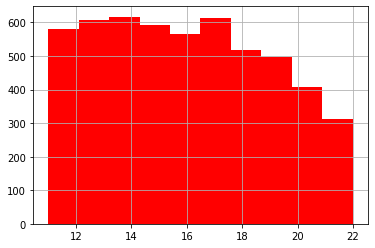

In [186]:
train['total_energy'].hist()

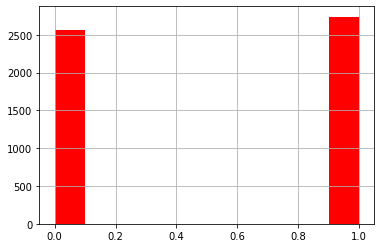

In [187]:
train['isPhoton'].hist()

In [188]:
def toNA(val):
    if val==-999:
        return np.nan
    else:
        return val

In [189]:
def to0(val):
    if val==-999:
        return 0
    else:
        return val

Try to make some engineered features based off the symmetry of a photon.

In [190]:
def integrated_perimeter(df):
    perimeter_values = [1,2,3,4,5,6,7,13,14,20,21,27,28,34,35,41,42,43,44,45,46,47,48]
    name = 'tower'
    df['integrated_perimeter'] = df['tower0']
    #df.drop(['tower0'])
    for i in perimeter_values:
        title = name+str(i)
        df['integrated_perimeter'] = df['integrated_perimeter']+df[title]
        #df.drop([title])
    return df
        

In [191]:
def max_finder(df):
    perimeter_values = [9,10,11,12,15,19,22,26,29,33,36,37,38,39,40]
    name = 'tower'
    df['max_perimeter'] = df['tower8']
    #df.drop(['tower0'])
    for i in perimeter_values:
        title = name+str(i)
        df['max_perimeter'] = df['max_perimeter']+df[title]
        #df.drop([title])
    return df

In [192]:
def asymmetry(df):
    top = [8,9,10,11,12,15,16,17,18,19]    
    bottom = [29,30,31,32,33,36,37,38,39,40]
    left = [8,9,15,16,22,23,29,30,36,37,43,44]
    right= [11,12,18,19,25,26,32,33,39,40]
    series1 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series2 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series3 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series4 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    name = 'tower'
    for i,j,k,c in zip(top,bottom,left,right):
        title = name+str(i)
        series1 = series1 + df[title]
        title = name+str(j)
        series2 = series2 + df[title]
        title = name+str(k)
        series3 = series3 + df[title]
        title = name+str(c)
        series4 = series4 + df[title]
    df['top_asymmetry'] = abs(series1-series2)
    df['left_asymmetry']= abs(series3-series4)
    return df

In [193]:
def preprocess(train):
    trainTransformed = pd.DataFrame()
    for column in train:
        trainTransformed[column]  = train[column].apply(to0)
    #print(trainTransformed.head())
    trainTransformed = integrated_perimeter(trainTransformed)
    trainTransformed = asymmetry(trainTransformed)
    trainTransformed = max_finder(trainTransformed)
    trainTransformed = trainTransformed.drop(['tower0','tower1','tower2','tower3','tower4','tower5','tower6','tower7','tower8','tower9','tower10','tower11','tower12','tower13','tower14','tower15','tower19','tower20','tower21','tower22','tower26','tower27','tower28','tower29','tower33','tower34','tower35','tower36','tower40','tower41','tower42','tower43','tower44','tower45','tower46','tower47','tower48'],axis=1)    
    df_temp = trainTransformed.drop(['isPhoton','total_energy'],axis=1)
    for column in df_temp:
        df_temp[column] = df_temp[column] / trainTransformed['total_energy']
    trainTransformed = trainTransformed[['isPhoton','total_energy']]
    trainTransformed = pd.concat([trainTransformed,df_temp.drop('Unnamed: 0',axis=1)],axis=1)
    return trainTransformed

In [194]:
train = preprocess(train)
test = preprocess(test)
#train = train.drop('total_energy',axis=1)
#test = test.drop('total_energy',axis=1)

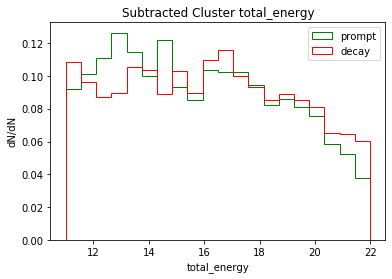

In [195]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['total_energy'].values,groups.get_group(1)['total_energy'].values], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("total_energy")
plt.ylabel("dN/dN")
plt.title("Subtracted Cluster total_energy")
plt.legend()
plt.show()

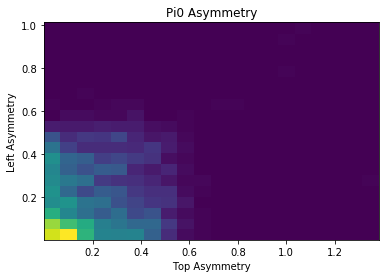

In [196]:
groups = train.groupby(['isPhoton'])
plt.hist2d(groups.get_group(0)['top_asymmetry'].values,
           groups.get_group(0)['left_asymmetry'].values,
           bins=20,density=True)
plt.xlabel("Top Asymmetry")
plt.ylabel("Left Asymmetry")
plt.title("Pi0 Asymmetry")
plt.show()

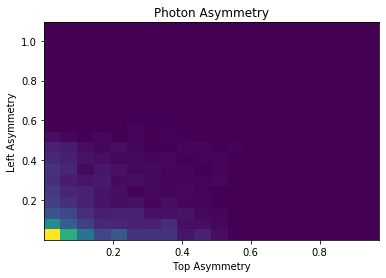

In [197]:
groups = train.groupby(['isPhoton'])
plt.hist2d(groups.get_group(1)['top_asymmetry'].values,
           groups.get_group(1)['left_asymmetry'].values,
           bins=20,density=True)
plt.xlabel("Top Asymmetry")
plt.ylabel("Left Asymmetry")
plt.title("Photon Asymmetry")
plt.show()

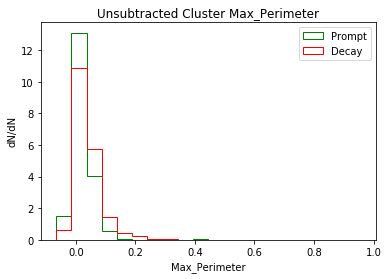

In [198]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['max_perimeter'].values,groups.get_group(1)['max_perimeter'].values], bins=20,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("Max_Perimeter")
plt.ylabel("dN/dN")
plt.title("Unsubtracted Cluster Max_Perimeter")
plt.legend()
plt.show()

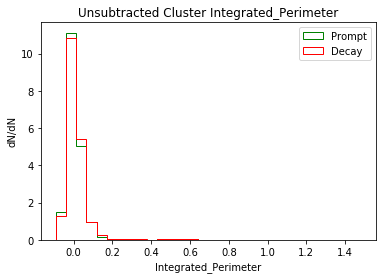

In [199]:
#more bins
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['integrated_perimeter'].values,groups.get_group(1)['integrated_perimeter'].values], bins=30,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("Integrated_Perimeter")
plt.ylabel("dN/dN")
plt.title("Unsubtracted Cluster Integrated_Perimeter")
plt.legend()
plt.show()

knn = kNN(train,test)

knn.score()

knn.best_param()

lda  = LDA(train,test)

In [162]:
logistic  = Logistic(train,test)

In [201]:
logistic.score()

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

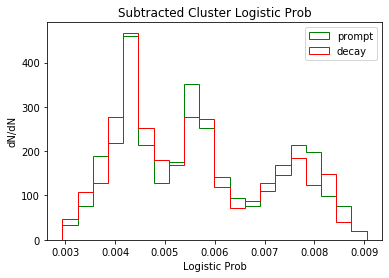

In [163]:
groups = test.groupby(['isPhoton'])
plt.hist([logistic.estimate(groups.get_group(0).drop(['isPhoton'],axis=1))[:,1]  , logistic.estimate(groups.get_group(1).drop(['isPhoton'],axis=1))[:,1]], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("Logistic Prob")
plt.ylabel("dN/dN")
plt.title("Subtracted Cluster Logistic Prob")
plt.legend()
plt.show()

logistic.score()

logistic.best_param()

In [200]:
randomForest = RandomForest(train,test)

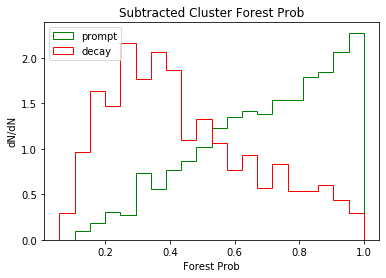

In [165]:
groups = test.groupby(['isPhoton'])
plt.hist([randomForest.estimate(groups.get_group(0).drop(['isPhoton'],axis=1))[:,1]  , randomForest.estimate(groups.get_group(1).drop(['isPhoton'],axis=1))[:,1]], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("Forest Prob")
plt.ylabel("dN/dN")
plt.title("Subtracted Cluster Forest Prob")
plt.legend(loc="upper left")
plt.show()

In [166]:
randomForest.score()

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [ ]:
randomForest.best_param()

In [ ]:
svc = SVC(train,test)

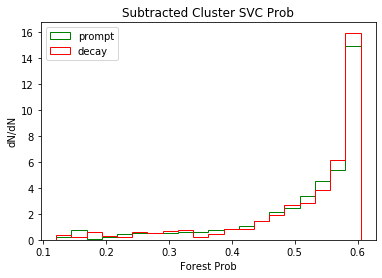

In [127]:
groups = test.groupby(['isPhoton'])
plt.hist([svc.estimate(groups.get_group(0).drop(['isPhoton'],axis=1))[:,1]  , svc.estimate(groups.get_group(1).drop(['isPhoton'],axis=1))[:,1]], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("Forest Prob")
plt.ylabel("dN/dN")
plt.title("Subtracted Cluster SVC Prob")
plt.legend(loc="upper left")
plt.show()

In [31]:
bdt = BDT(train,test)

In [88]:
bdt.score()

test score = 0.8751529987760098


In [89]:
bdt.best_param()

{'learning_rate': 0.01, 'n_estimators': 10000}


In [32]:
mlp = MLP(train,test)

/Users/francescovassalli/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [80]:
mlp.score()

test score = 0.8531211750305998


In [81]:
mlp.best_param()

{'alpha': 0.0001, 'epsilon': 1e-09, 'hidden_layer_sizes': [17, 17], 'learning_rate_init': 0.1}


Logistic
RandomForest


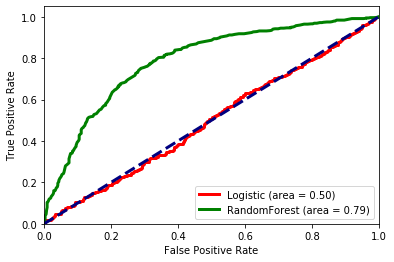

In [119]:
algos = [logistic,randomForest]
plotRoc(algos)

In [19]:
def clusterMap(event):
    cluster = []
    for i in range(0,7):
        row=[]
        for j in range(0,7):
            row.append(event['tower'+str(7*i+j)])
        cluster.append(row)
    cluster = np.array(cluster)
    fig, ax = plt.subplots()
    p = ax.imshow(cluster)
    for i in range(0,7):
        for j in range(0,7):
            text = ax.text(j, i, round(cluster[i, j], 2),
                       ha="center", va="center", color="w")
    ax.set_title(round(event['total_energy'],2))


In [16]:
def csvNoMix(signal):
    df = pd.read_csv(signal)
    df = df.groupby(['isPhoton']).get_group(1)
    df = df.drop(['isPhoton'], axis=1)
    df['pid'] = df['pid'].apply(removeCombined)
    df = df.dropna()
    df['pid'] = df['pid'].apply(pid2Type)
    df = df.rename(columns = {'pid':'isPhoton'})
    df = df[df['total_energy']<22]
    df = df[df['total_energy']>11]
    return df

In [58]:
signal = csvNoMix("photonclusters.csv")
back = csvNoMix("backclusters.csv")

Prompt Events
Sasha = 0.056202951818704605
Sasha = 0.11891533434391023
Sasha = 0.021168183535337448


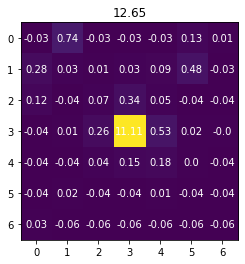

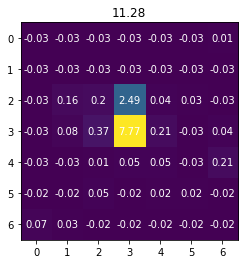

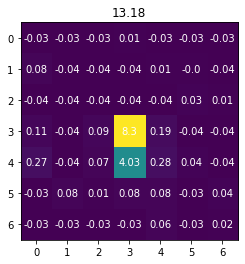

In [59]:
print("Prompt Events")
clusterMap(signal.iloc[0])
print("Sasha = "+str(signal.iloc[0]['sProb']))
clusterMap(signal.iloc[1])
print("Sasha = "+str(signal.iloc[1]['sProb']))
clusterMap(signal.iloc[2])
print("Sasha = "+str(signal.iloc[2]['sProb']))

signalp  = preprocess (signal)
signalp = signalp.drop(['isPhoton','sProb'],axis=1)
#randomForest.classifier.predict_proba([signalp.iloc[i] for i in range(0,3)])



Decay Events
Sasha = 0.1329900324344635
Sasha = 0.004254590719938278
Sasha = 0.034241382032632835


array([[1.   , 0.   ],
       [0.992, 0.008],
       [0.964, 0.036]])

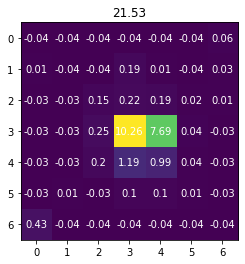

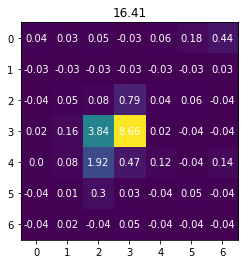

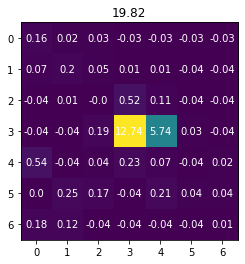

In [546]:
print("Decay Events")
clusterMap(back.iloc[0])
print("Sasha = "+str(back.iloc[0]['sProb']))
clusterMap(back.iloc[1])
print("Sasha = "+str(back.iloc[1]['sProb']))
clusterMap(back.iloc[2])
print("Sasha = "+str(back.iloc[2]['sProb']))

backp  = preprocess (back)
backp = backp.drop(['isPhoton','sProb'],axis=1)
randomForest.classifier.predict_proba([backp.iloc[i] for i in range(0,3)])

